#### Step 1: Load Ground Truth Dataset

In [10]:
import pandas as pd
df_ground_truth = pd.read_csv('ground-truth-data.csv')
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [11]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [12]:
import json

with open('documents-with-ids.json', 'rt') as f_in:
    documents = json.load(f_in)

In [13]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['course']

'machine-learning-zoomcamp'

#### Step 2: Create Embeddings using Pretrained Models

Sentence Transformers documentation here: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

In [14]:

from sentence_transformers import SentenceTransformer
model_name = 'multi-qa-MiniLM-L6-cos-v1'

model = SentenceTransformer(model_name)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/python/3.12.1/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
len(model.encode("This is a simple sentence"))

384

In [16]:
documents[1]

{'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp',
 'id': '1f6520ca'}

#### Step 3: Setup ElasticSearch connection 

In [17]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch('http://localhost:9200') 

es_client.info()

ObjectApiResponse({'name': 'b8d182300f91', 'cluster_name': 'docker-cluster', 'cluster_uuid': '_3--bU5ORBmSPSTkZjsNsw', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

#### Step 4: Create Mappings and Index

* Mapping is the process of defining how a document, and the fields it contains, are stored and indexed.

* Each document is a collection of fields, which each have their own data type.

* We can compare mapping to a database schema in how it describes the fields and properties that documents hold, the datatype of each field (e.g., string, integer, or date), and how those fields should be indexed and stored 



In [18]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} ,
            "question_text_vector": {
                "type": "dense_vector", 
                            "dims": 384, 
                            "index": True,
                              "similarity": "cosine"},
        }
    }
}

In [19]:
index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [20]:
from tqdm.auto import tqdm

In [15]:
for doc in tqdm(documents):
    # Transforming the title into an embedding using the model
    question = doc["question"]
    text = doc['text']
    doc["question_text_vector"] = model.encode(question+ ' ' + text)
    es_client.index(index= index_name, document= doc)

100%|██████████| 948/948 [00:58<00:00, 16.22it/s]


### Searching based on knn

In [21]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']
   
    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)



In [17]:
question_text_vector_knn(dict
                         (question = "What if I miss a session?", 
                          course= 'machine-learning-zoomcamp'))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Useful Resource for Missing Data Treatment\nhttps://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python/notebook',
  'course': 'machine-learning-zoomcamp',
  'section': '2. Machine Learning for Regression',
  'text': '(Hrithik Kumar Advani)',
  'id': '81b8e8d0'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your qu

### Building RAG Flow 

In [22]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [23]:
from dotenv import load_dotenv
import os

# Load .env file
load_dotenv()

# Access the API key
openai_api_key = os.getenv("OPENAI_API_KEY")


In [24]:
from openai import OpenAI



client = OpenAI(api_key=openai_api_key)



In [25]:
def llm(prompt):
    response = client.chat.completions.create(
      model="gpt-4o-mini-2024-07-18",
      messages=[
        {
          "role": "user",
          "content": prompt,
        },
      ],
    )
    return response.choices[0].message.content

In [26]:
def rag(query: dict) -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt)
    return answer

In [27]:
rag(ground_truth[10])

'Yes, sessions for the machine learning Zoomcamp are recorded, so if you miss one, you will be able to watch the recording later.'

In [28]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

In [40]:
doc_idx['5170565b']

{'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'section': 'General course-related questions',
 'question': 'What if I miss a session?',
 'course': 'machine-learning-zoomcamp',
 'id': '5170565b'}

### Cosine Similarity

In [42]:
answers = {}
for i, rec in enumerate(tqdm(ground_truth)) :
    if i in answers: 
        continue
    answer_llm = rag(rec)
    doc_id = rec['document']
    answer_orig = doc_idx[doc_id]['text'] 
    question = doc_idx[doc_id]['question'] 
    course = doc_idx[doc_id]['course'] 

    answers[i]= {
        'answer_llm' : answer_llm,
        'answer_orignal': answer_orig,
        'document':  doc_id,
        'question': question,
        'course':  course
        }


100%|██████████| 1830/1830 [34:01<00:00,  1.12s/it] 


In [43]:
result_gpt_4 = pd.DataFrame(answers.values())

In [44]:
result_gpt_4.to_csv("gtp4_dataframe", index = False)

In [45]:
result_gpt_4 = [None] * len(ground_truth)

In [46]:
for i, val in answers.items():
    result_gpt_4[i] = val.copy()
    result_gpt_4[i].update(ground_truth[i])

In [47]:
result_gpt_4[0]

{'answer_llm': "I'm sorry, but it seems that I do not have access to the specific details of the CONTEXT from the FAQ database. Please provide me with the relevant information or details, and I will be happy to assist you with your question about signing up for the course.",
 'answer_orignal': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

### Evaluating GPT4-o-mino

In [48]:
result_gpt_4 = pd.read_csv("gtp4_dataframe")

In [49]:
result_gpt_4.columns

Index(['answer_llm', 'answer_orignal', 'document', 'question', 'course'], dtype='object')

In [50]:
records = result_gpt_4.to_dict(orient = 'records')

In [51]:
def compute_cosine_similarity(records):
    answer_orig= rec["answer_orignal"]
    answer_llm = rec['answer_llm']
    v_org = model.encode(answer_orig)
    v_llm = model.encode(answer_llm)
    return v_llm.dot(v_org)

In [52]:
similarity = []

for rec in tqdm(records):
    sim = compute_cosine_similarity(rec)


    similarity.append(sim)

100%|██████████| 1830/1830 [01:28<00:00, 20.72it/s]


In [53]:
result_gpt_4['cosine']= similarity

In [54]:
result_gpt_4['cosine'].describe()

count    1830.000000
mean        0.473291
std         0.273820
min        -0.217626
25%         0.306393
50%         0.541943
75%         0.687911
max         0.957375
Name: cosine, dtype: float64

In [55]:
import seaborn as sns 

/tmp/ipykernel_13102/3273508558.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(result_gpt_4['cosine'])


<Axes: xlabel='cosine', ylabel='Density'>

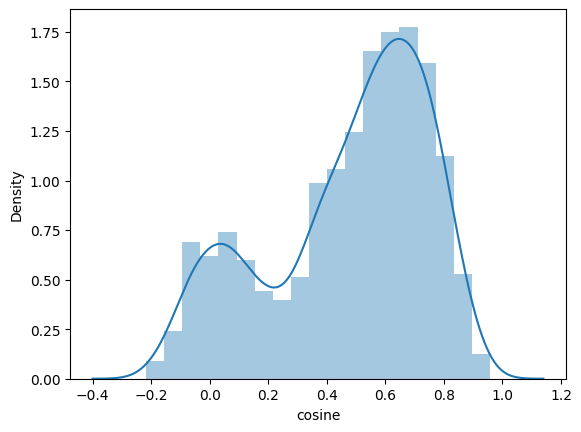

In [56]:
sns.distplot(result_gpt_4['cosine'])

### LLM as Judge

In [58]:

prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {original_answer}
Generated Question: {generated_question}
Generated Answer: {generated_answer}

Please analyze the content and context of the generated answer in relation to the original answer and provide your evaluation in JSON format:

{
    "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
    "Explanation": "[Provide a brief explanation for your evaluation]"
}
""".strip()


prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it 
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Generated Question: {generated_question}
Generated Answer: {generated_answer}

Please analyze the content and context of the generated answer in relation to the question and provide your evaluation in JSON format:

{
    "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
    "Explanation": "[Provide a brief explanation for your evaluation]"
}
""".strip()


In [60]:
df_sampels = result_gpt_4.sample(n=150, random_state=1)